# Projeto: Credit Score Prediction


## Visão Geral
Sistema de machine learning para identificação de potenciais maus pagadores (credit scoring) baseado em dados históricos de clientes. O projeto foca na construção de uma solução robusta com:

- **Arquitetura modular** utilizando classes e funções especializadas
- Pipeline completo de processamento de dados e visualizações
- Implementação com CatBoost para máxima eficiência

## Justificativa para uso do CatBoost
| Vantagem | Descrição |
|----------|-----------|
| **Nativo com dados categóricos** | Processa colunas categóricas sem pré-processamento |
| **Alto desempenho** | Algoritmo gradient boosting otimizado para velocidade |
| **Resistente a overfitting** | Mecanismos internos de regularização |
| **Interpretabilidade** | Gera importância de features automaticamente |
| **Suporte a texto** | Processamento integrado de features textuais |

## Dataset Structure
Dados obtidos do [Kaggle](https://www.kaggle.com/datasets/parisrohan/credit-score-classification) contendo:

### Tabela de Features
| Nome da Coluna | Descrição/Função |
|----------------|------------------|
| ID | Identificador único do registro |
| Customer_ID | Identificador único do cliente |
| Month | Mês de referência dos dados |
| Name | Nome do cliente |
| Age | Idade do cliente |
| SSN | Número do seguro social |
| Occupation | Profissão do cliente |
| Annual_Income | Renda anual |
| Monthly_Inhand_Salary | Salário líquido mensal |
| Num_Bank_Accounts | Número de contas bancárias |
| Num_Credit_Card | Número de cartões de crédito |
| Interest_Rate | Taxa de juros média |
| Num_of_Loan | Número de empréstimos ativos |
| Type_of_Loan | Tipos de empréstimos contratados |
| Delay_from_due_date | Dias de atraso em pagamentos |
| Num_of_Delayed_Payment | Número de pagamentos atrasados |
| Changed_Credit_Limit | Variação no limite de crédito |
| Num_Credit_Inquiries | Consultas recentes ao crédito |
| Credit_Mix | Mix de produtos de crédito |
| Outstanding_Debt | Dívida total pendente |
| Credit_Utilization_Ratio | Utilização do limite de crédito |
| Credit_History_Age | Tempo de histórico creditício |
| Payment_of_Min_Amount | Paga apenas valor mínimo? |
| Total_EMI_per_month | Parcelamentos mensais totais |
| Amount_invested_monthly | Valor mensal investido |
| Payment_Behaviour | Padrão de comportamento de pagamento |
| Monthly_Balance | Saldo mensal disponível |
| Credit_Score | Target: Good/Standard/Poor |

## Abordagem Técnica
1. **Pré-processamento inteligente** com tratamento de:
   - Valores faltantes
   - Dados categóricos/textuais
   - Normalização de features numéricas <br><br>

2. **Engenharia de features** para criar indicadores adicionais 

3. **Modelagem com CatBoost** utilizando:
   - Validação cruzada
   - Early stopping
   - Otimização de hiperparâmetros <br><br>

4. **Análise de resultados** com:
   - Métricas de classificação multiclasse
   - Matriz de confusão
   - Curvas de aprendizado

# Pacotes e Dataset

## Pacotes

In [1]:
# Bibliotecas Padrões
import os
import re
import string
import warnings
import itertools
import pickle
import statistics
import shutil
from zipfile import ZipFile

# Bibliotecas Gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import CatBoostClassifier, cv, Pool

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import sklearn.impute

# SciPy
from scipy.stats import boxcox, skew, kurtosis, normaltest
from scipy.stats.contingency import chi2_contingency



# Pequenas configurações gráficas

warnings.filterwarnings('ignore')
np.printoptions(pricision=2)
pd.set_option('display.max_columns', 30)

## Datasets  

1. Criei um dicionário para as colunas já definindo o tipo, deixando o código mais rápido.
2. Juntei o treino e o teste, mas criei a coluna `treino` para diferenciar os dados.

In [2]:
dtypes = dict(
    Month="category",
    Name="category",
    Occupation="category",
    Type_of_Loan="category",
    Credit_History_Age="category",
    Payment_Behaviour="category"
)


train_df = pd.read_csv("dados/train.csv", dtype=dtypes, parse_dates=['Month'])
train_df["treino"] = True
test_df = pd.read_csv("dados/test.csv", dtype=dtypes, parse_dates=['Month'])
test_df["treino"] = False
df = pd.concat([train_df, test_df])

In [3]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,treino
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,True
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,True
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,True
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,True
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,True


* Vou conferir a coluna `Credit_Mix` para ver se não possui algum valor fora do padrão

In [4]:
np.unique(df["Credit_Mix"])

array(['Bad', 'Good', 'Standard', '_'], dtype=object)

* Temos os valores `Bad`, `Good` e `Standard` que são os que queremos, contudo, possuimos também o valor `_` que pode possivelmente é um erro, trataremos ele abaixo.

# Processamento de Dados

## Ordem de processamento:


1. *Dropar* colunas que não são importantes
2. Utilizaremos a classe `DataProcessor` como classe principal para o pré-processamento com diversos métodos que serão detalhados abaixo.
<br><br>


* Motivos para Excluir Variáveis como `Name`, `SSN` e `ID`

1. **Privacidade e Conformidade**  
    - Dados como `Nome` e `SSN` identificam indivíduos, violando regulamentações **(GDPR, LGPD)**. <br><br>  

2. **Evitar Data Leakage e *Overfitting***  
    - IDs únicos podem causar *overfitting*.  <br><br>

3.  **Alta Cardinalidade Inútil**  
    - `Name` tem valores quase únicos, além de não possuírem relação estatística com o nosso *target*.  <br><br>

4.  **Performance**  
    - Reduz dimensionalidade, acelerando treinamento de modelos.  

In [5]:
df.drop(["Name", "SSN", "ID"], axis=1, inplace=True, errors="ignore") # Dropping irrelevant columns

## Classe `ProcessadorDeDados`

Este código Python define uma classe versátil `DataProcessor` para pré-processar e limpar dados de forma eficiente em um `DataFrame`. A classe inclui vários métodos, cada um projetado para executar tarefas específicas de limpeza e transformação de dados:

- **`obter_mes`**: Este método extrai e calcula meses a partir de strings no formato de data encontradas nos dados.  

- **`obter_numeros`**: Um método estático que extrai valores numéricos de strings de texto, útil para limpar colunas com dados mistos.  

- **`substituir_caracteres_especiais`**: Outro método estático que substitui caracteres especiais e trata casos específicos como `"NM"` e `"payments"`.  

- **`preprocessar_texto`**: Este método estático tokeniza e processa textos, criando um dicionário de tokens únicos e retornando strings limpas e tokenizadas.  

- **`preencher_na`**: Este método preenche valores ausentes em colunas categóricas e numéricas com base em um agrupamento especificado.  

- **`preprocessar`**: O principal método de pré-processamento da classe. Aplica uma série de transformações ao `DataFrame`, como:  
  - Extrair números da coluna `'Age'`,  
  - Aplicar a função `replace_special_character` a todo o `DataFrame`,  
  - Tratar as colunas `'Credit_Mix'` e `'Payment_Behaviour'`,  
  - Tokenizar os valores de `'Type_of_Loan'`,  
  - Converter valores de `'Credit_History_Age'`,  
  - Lidar com valores ausentes usando o método `fill_na`.  

**Por que usar a classe `ProcessadorDeDados`?**  
Ela permite preparar dados de forma eficiente para análise ou modelagem, garantindo que estejam:  
1. Limpos,  
2. Estruturados,  
3. Prontos para uso.  

> Seus métodos reutilizáveis resolvem desafios comuns de pré-processamento, tornando-a uma ferramenta valiosa em fluxos de trabalho de **análise de dados** ou **Machine Learning**.


In [6]:
class ProcessadorDeDados:

    def __init__(self, agrupar_por, dataframe):
        self.agrupar_por = agrupar_por
        self.df = dataframe

    def obter_mes(self, x):
        if not pd.isnull(x):
            ano_mes = re.findall(r"\d+", x)
            meses = (int(ano_mes[0])*12) + np.int64(ano_mes[-1])
            return meses
        else:
            x

    @staticmethod
    def obter_numeros(texto):
        digitos = re.findall(r'\d+', str(texto))
        digitos = ','.join(digitos)
        return digitos

    @staticmethod
    def substituir_caracteres_especiais(texto):
        if "NM" in str(texto):
            return "Não"

        if "payments" in str(texto) or "_" not in str(texto):
            return texto

        texto_limpo = str(texto).replace("_", "")
        return np.nan if texto_limpo == "nan" else texto_limpo

    @staticmethod
    def preprocessar_texto(textos: str) -> tuple[dict, list[list[str]]]:
        dicionario = {}

        tokens = [str(texto).lower().replace("and", "").split(",") for texto in textos]
        tokens = [[token.strip() for token in lista_tokens if token not in string.punctuation] for lista_tokens in tokens]
        for lista_tokens in tokens:
            for token in lista_tokens:
                if token not in dicionario:
                    tamanho = len(dicionario)
                    dicionario[token] = tamanho
        return (dicionario, ["|".join(palavras) for palavras in tokens])

    @staticmethod
    def preencher_na(df: pd.DataFrame, agrupar_por=None):
        features_categoricas = df.select_dtypes(exclude="number").columns.drop(
            ["treino", "Credit_Score", "Type_of_Loan"])
        features_numericas = df.select_dtypes(include="number").columns

        df["Type_of_Loan"].fillna("não especificado", inplace=True)

        def preencher_na_cat(df):
            df[features_categoricas] = df.groupby(agrupar_por)[features_categoricas].transform(
                lambda x: x.fillna(x.mode()[0]))
            return df

        def preencher_na_num(df):
            df[features_numericas] = df.groupby(agrupar_por)[features_numericas].transform(
                lambda x: x.fillna(x.median()))
            return df

        df = preencher_na_cat(df)
        df = preencher_na_num(df)
        return df

    def preprocessar(self):
        self.df['Age'] = self.df.Age.apply(ProcessadorDeDados.obter_numeros)
        self.df = self.df.applymap(ProcessadorDeDados.substituir_caracteres_especiais)
        self.df = self.df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
        self.df["Credit_Mix"] = self.df.groupby(self.agrupar_por)["Credit_Mix"].transform(lambda x: x.replace("", x.mode()[0]))
        self.df["Payment_Behaviour"] = self.df.groupby(self.agrupar_por)["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8" if x.mode()[0] != "@9#%8" else np.nan)
        )
        self.df["Type_of_Loan"] = self.df[["Type_of_Loan"]].apply(lambda x: ProcessadorDeDados.preprocessar_texto(x.values)[-1])
        self.df["Type_of_Loan"] = self.df["Type_of_Loan"].str.replace(" ", "_").str.replace("|", " ")
        self.df["Credit_History_Age"] = self.df["Credit_History_Age"].apply(lambda x: self.obter_mes(x))
        self.df["Monthly_Balance"] = pd.to_numeric(self.df.Monthly_Balance, errors="coerce")
        self.df = ProcessadorDeDados.preencher_na(self.df, "Customer_ID")

        return self.df

Além de utilizar a classe, iremos fazer algumas mudanças pequenas:

1. **Substituindo saldos de conta menores que zero por zero**  

2. **Padronizando valores "nan" como NaN** (para consistência):  
    - Na coluna `'Type_of_Loan'`  
    - Na coluna `'Occupation'`  
    - Na coluna `'Credit_Mix'`  

In [7]:
processador = ProcessadorDeDados("Customer_ID", df)
data = processador.preprocessar()


data.loc[df["Num_Bank_Accounts"]<0, "Num_Bank_Accounts"] = 0  
data.loc[data["Type_of_Loan"]=="nan", "Type_of_Loan"] = np.nan  
data.loc[data["Occupation"] == "", "Occupation"] = np.nan  
data.loc[data["Credit_Mix"] == "", "Credit_Mix"] = np.nan  

## Remoção personalizada de Outliers

O código Python fornecido define uma classe `ClipOutliersTransformer` e funções para remoção de outliers e correção de assimetria em um DataFrame do pandas.


### **Classe `ClipOutliersTransformer`**
Classe projetada para transformar dados numéricos através do *clipping* de outliers.  
**Parâmetros principais**:  
- `lower_quantile` e `upper_quantile`: Quantis para definir os limites de corte.  
- `multiplier`: Multiplicador para ajustar os limites de *clipping*.  
- `replace_with_median`: Se `True`, substitui outliers pela mediana.  

**Métodos**:  
- **`fit`**: Calcula os limites de corte (*clipping*) com base nos quantis.  
- **`transform`**: Aplica a transformação de *clipping* aos dados.  



### **Funções Auxiliares**  

1. **`get_skewness`**  
   Calcula a assimetria (*skewness*) das colunas numéricas de um DataFrame e as classifica em:  
   - **Altamente assimétricas** (*highly skewed*)  
   - **Pouco assimétricas** (*lowly skewed*)  
   com base em limites definidos pelo usuário.  <br><br>

2. **`remove_outliers`**  
   Remove outliers e corrige assimetria em colunas numéricas.  
   **Fluxo**:  
   - Identifica colunas altamente/pouco assimétricas usando `get_skewness`.  
   - Aplica `ClipOutliersTransformer`:  
     - Para colunas **altamente assimétricas**: Corta outliers e substitui pela mediana.  
     - Para colunas **pouco assimétricas**: Apenas corta outliers (sem substituição).  



### **Vantagens**  
- **Flexibilidade**: Permite ajustar limites de corte e tratamento de outliers.  
- **Melhoria na qualidade dos dados**: Reduz distorções para análises ou modelos mais precisos.  
- **Integração simples**: Compatível com pipelines do scikit-learn.  


In [8]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,
                 lower_quantile,
                 upper_quantile,
                 multiply_by=1.5,
                 replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median

        self.lower_limit = 0
        self.upper_limit = 0
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        # self.feature_names_in_ = X.columns.tolist()

        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(
                ((X >= self.lower_limit) & (X <= self.upper_limit)), X,
                np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)


def get_skewness(df, lower=None, upper=None):
    columns = df.columns
    skewness: pd.Series = df[columns].skew()
    highly_skewed = skewness[(skewness <= lower) |
                             (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower)
                            & (skewness < upper)].index.to_list()
    return (highly_skewed, lowly_skewed)


def remove_outliers(df: pd.DataFrame):
    category = df.select_dtypes(exclude="number").columns.drop(
        ["Credit_Score"])
    numbers = df.select_dtypes(include="number").columns

    highly_skewed, lowly_skewed = get_skewness(df[numbers],
                                               lower=-0.8,
                                               upper=0.8)

    df[highly_skewed] = df[highly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=True).
        fit_transform(x))

    df[lowly_skewed] = df[lowly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=False).
        fit_transform(x))
    return df

In [9]:
data = remove_outliers(data)

# Visualização de dados com Boxplot  
 

# Catboost

## Visualização de Dados com Box Plots e Intuição

O código Python fornecido define funções para criar **box plots** (gráficos de caixa), uma ferramenta poderosa para visualizar a distribuição de dados numéricos.


### **Intuição por trás dos Box Plots**  
Box plots representam graficamente:  
- **Tendência central** (mediana = linha dentro da caixa)  
- **Disperção** (intervalo interquartil, IQR = "caixa")  
- **Outliers** (pontos fora dos "bigodes")  

**Elementos do gráfico**:  
- **Caixa**: Abrange o IQR (25º ao 75º percentil).  
- **Linha central**: Mediana (50º percentil).  
- **Bigodes**: Estendem-se até 1.5×IQR (ou até os valores mínimos/máximos dentro desse limite).  
- **Pontos isolados**: Valores fora dos bigodes = outliers.  


### **Funções Implementadas**  

1. **`make_boxplot`**  
   Cria um box plot para uma coluna numérica específica em relação à coluna `'Credit_Score'`, permitindo comparar a distribuição da variável entre diferentes grupos de pontuação de crédito.  

2. **`plot_boxplot_num_cols`**  
   Automatiza a geração de box plots para **todas as colunas numéricas** do DataFrame, facilitando a análise comparativa.  



### **Por que usar Box Plots?**  
- **Identificação rápida de outliers** (valores atípicos).  
- **Comparação de distribuições** entre grupos/categorias.  
- **Análise de assimetria** e variabilidade dos dados.  

## Funções para o gráfico

In [10]:
def make_boxplot(df, column, ax):
    sns.boxplot(x="Credit_Score", y=column, data=df, ax=ax, width=0.8, hue = "Credit_Score", palette="Set2")
    plt.xticks(rotation=90)
    plt.title(column, fontdict={"fontsize": 10})
    plt.xticks(rotation=0)

def plot_boxplot_num_cols(df):
    fig = plt.figure(figsize=(18, 14), dpi=300)
    numb_columns = df.select_dtypes(include="number").columns
    for column in numb_columns:
        ax = fig.add_subplot(5, 4, list(numb_columns).index(column)+1)
        make_boxplot(df, column, ax)
        plt.tight_layout(pad=0.3)
    plt.tight_layout()
    plt.show()


# Adições extras:
plt.rc(("xtick", "ytick", "text"), c="k")
plt.rc("figure", dpi=80)

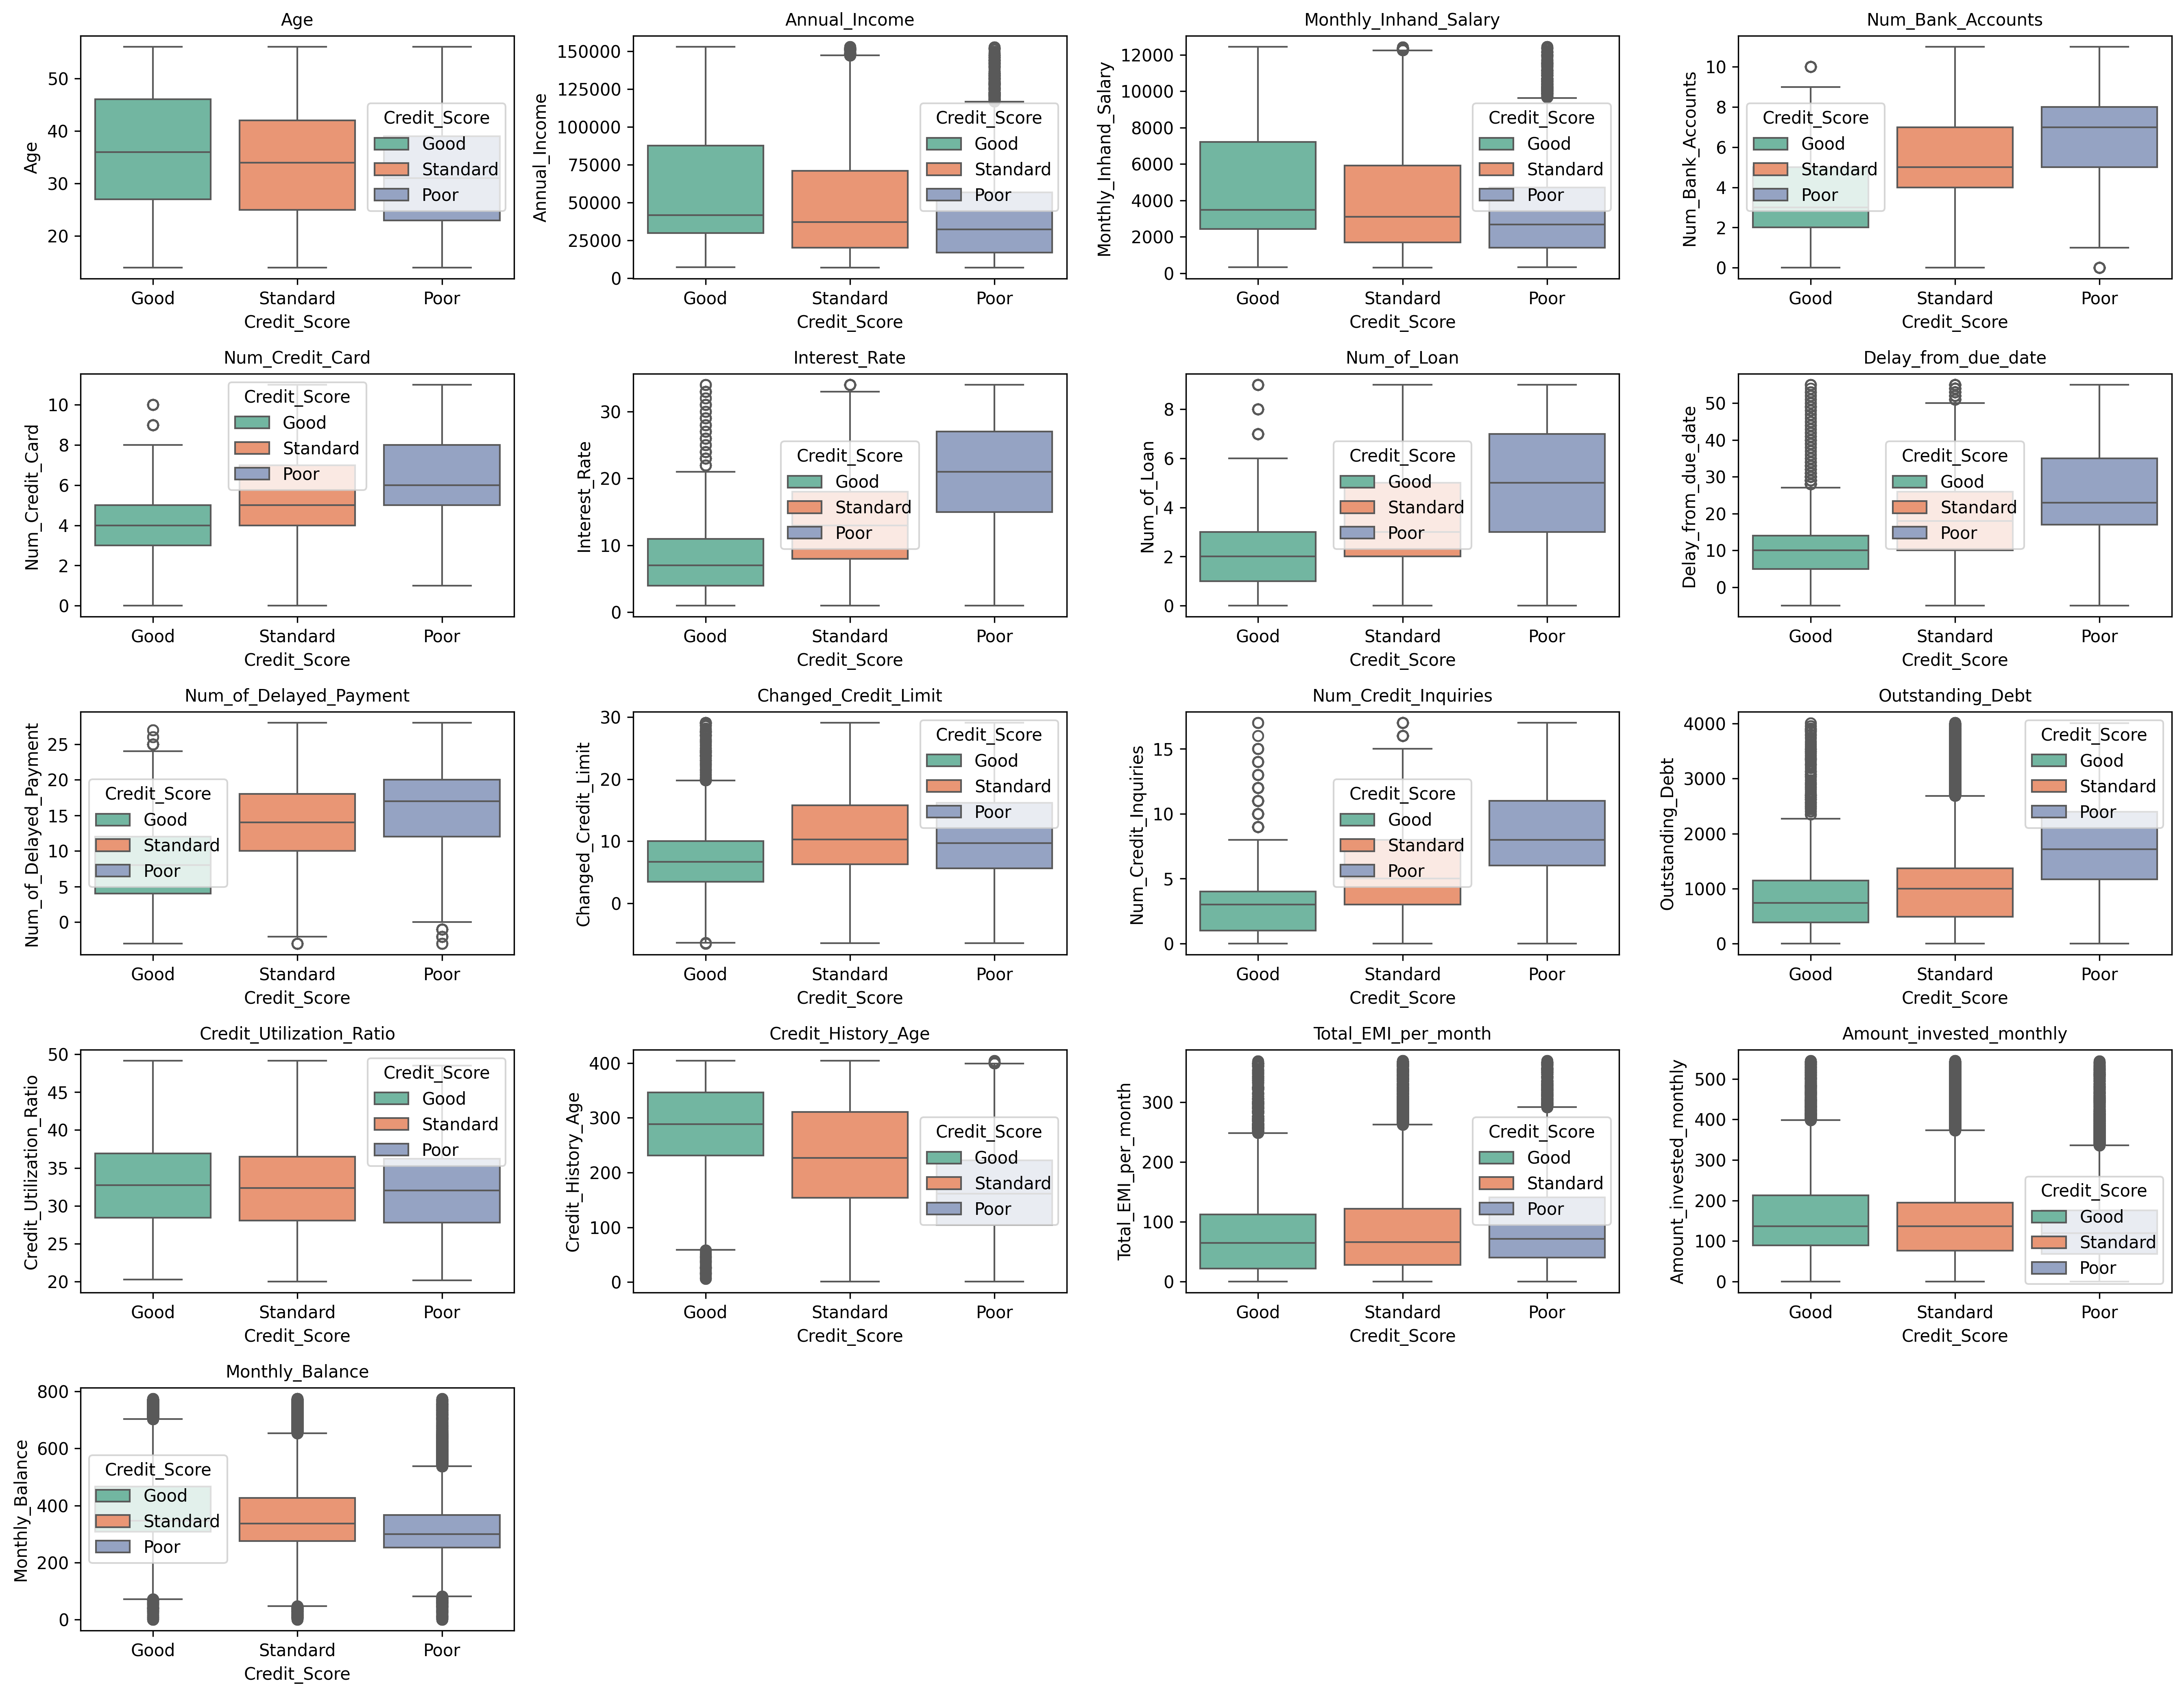

In [11]:
plot_boxplot_num_cols(data)

### Salvando o dataframe *limpo*

In [12]:
data.to_csv("dados/dados_limpo.csv", index=False)
df = pd.read_csv("dados/dados_limpo.csv")

## Crosstab + gráficos

In [13]:
df_copy = data.copy()
df_copy["Monthly_Balance"] = df_copy.groupby("Customer_ID")["Monthly_Balance"].transform(lambda x: np.where((x>np.quantile(x, 0.75)) | x<np.quantile(x, 0.75), np.median(x), x))

cross_tab = pd.crosstab(values=df_copy["Monthly_Balance"], index=[
                        df_copy["Credit_Score"], df_copy["Credit_Mix"]], columns="Monthly_Balance", aggfunc="mean").reset_index()

main_group = pd.pivot_table(cross_tab, "Monthly_Balance", "Credit_Score", aggfunc=np.mean)
cross_tab

col_0,Credit_Score,Credit_Mix,Monthly_Balance
0,Good,Bad,296.320348
1,Good,Good,403.335501
2,Good,Standard,387.642526
3,Poor,Bad,300.345681
4,Poor,Good,401.109600
5,Poor,Standard,343.470179
6,Standard,Bad,290.381714
7,Standard,Good,397.612596
8,Standard,Standard,387.203665


### Gráfico

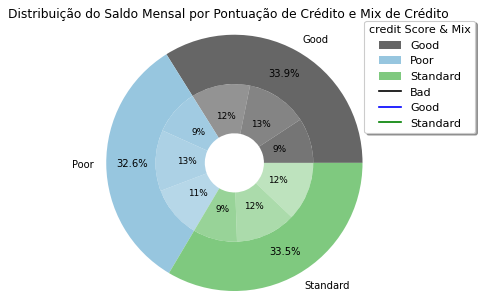

In [14]:
b = plt.cm.Blues
a = plt.cm.Accent

fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle('Distribuição do Saldo Mensal por Pontuação de Crédito e Mix de Crédito',
             fontsize=11,
             color="k")

fig.set_frameon(True)

pie1, *_, texts = ax.pie(x=main_group["Monthly_Balance"],
                         labels=main_group.index,
                         autopct="%.1f%%",
                         radius=1.3,
                         colors=[a(80, 1), b(100, 1),
                                 a(0, 1)],
                         pctdistance=0.8,
                         textprops={"size": 9},
                         frame=True)
plt.setp(pie1, width=0.5)
ax.set_frame_on(True)

pie2, *_, texts = ax.pie(x=cross_tab["Monthly_Balance"],
                         autopct="%.0f%%",
                         radius=0.8,
                         colors=[
                             a(80, 0.9),
                             a(80, 0.8),
                             a(80, 0.7),
                             b(100, 0.9),
                             b(100, 0.8),
                             b(100, 0.7),
                             a(0, 0.8),
                             a(0, 0.65),
                             a(0, 0.5)
],
    textprops={"size": 8})
plt.setp(pie2, width=0.5)
legend_labels = np.unique(cross_tab["Credit_Mix"])

legend_handles = [
    plt.plot([], label=legend_labels[0], c="k"),
    plt.plot([], label=legend_labels[1], c='b'),
    plt.plot([], label=legend_labels[-1], c="g")
]
plt.legend(shadow=True,
           frameon=True,
           facecolor="inherit",
           loc="best",
           title="credit Score & Mix",
           bbox_to_anchor=(1, 1, 0.5, 0.1))


plt.show()

### Insight rápido

**Principais Observações:**

1. **Credit Mix = Good tem os melhores saldos**  
   - Em TODAS as categorias de Credit Score, o mix "Good" apresenta os maiores saldos médios.  
   - Ex: Para Credit Score "Good" → Good (403.34) > Standard (387.64) > Bad (296.32) <br><br>

2. **Credit Mix = Bad limita o potencial**  
   - Quando o mix é "Bad", os saldos ficam estagnados em ~290-300  
   - Isso ocorre INDEPENDENTE do Credit Score (Good/Poor/Standard) <br><br>

3. **Credit Score "Good" tem vantagem, mas não quando o mix é ruim**  
   - Com mix "Good" ou "Standard": Good Score tem saldo levemente maior  
   - Com mix "Bad": diferença entre scores é mínima (<4%) <br><br>

**Insight Principal:**  
Ter um Credit Mix "Good" é mais impactante que ter um Credit Score alto

## Countplot

In [15]:
def make_countplot(df: pd.DataFrame):

    cat_cols = df.select_dtypes(exclude="number").columns.drop(
        ['Credit_Score', 'treino', 'Customer_ID', "Type_of_Loan"])
    cat_cols = list(cat_cols)
    cat_cols.pop(-1)
    cat_cols.insert(-2, "Payment_Behaviour")

    fig, axes = plt.subplots(figsize=(12, 6), dpi=300)
    fig.suptitle("Counts of categorical columns")
    axes.grid(visible=False)
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.set_tick_params(labelleft=False)

    def __plot_graph(df, col, ax: plt.Axes, legend=False):
        sns.countplot(
            data=df,
            x=col,
            ax=ax,
            hue="Credit_Score",
        )
        label =ax.get_xlabel()
        ax.set_xlabel(col, fontdict={"size": 9})
        ax.set_title(f"by {col}", fontdict={"size": 9})
        ax.get_xticklabels()
        ax.tick_params(labelsize=7, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(),
                           rotation=90,
                           fontdict=dict(size=7))
        ax.grid(False)
        if legend:
            ax.legend(shadow=True,
                      loc="best",
                      facecolor="inherit",
                      frameon=True)
        else:
            ax.legend_ = None
        plt.tight_layout(w_pad=1)

    for i, col in enumerate(cat_cols, 1):
        if i == 3:
            continue
        ax = fig.add_subplot(2, 3, i)
        __plot_graph(df, col=col, ax=ax)

    ax2 = fig.add_axes((0.74, 0.527, 0.23, 0.35))
    __plot_graph(df, col="Payment_Behaviour", ax=ax2, legend=True)
    plt.show(True)

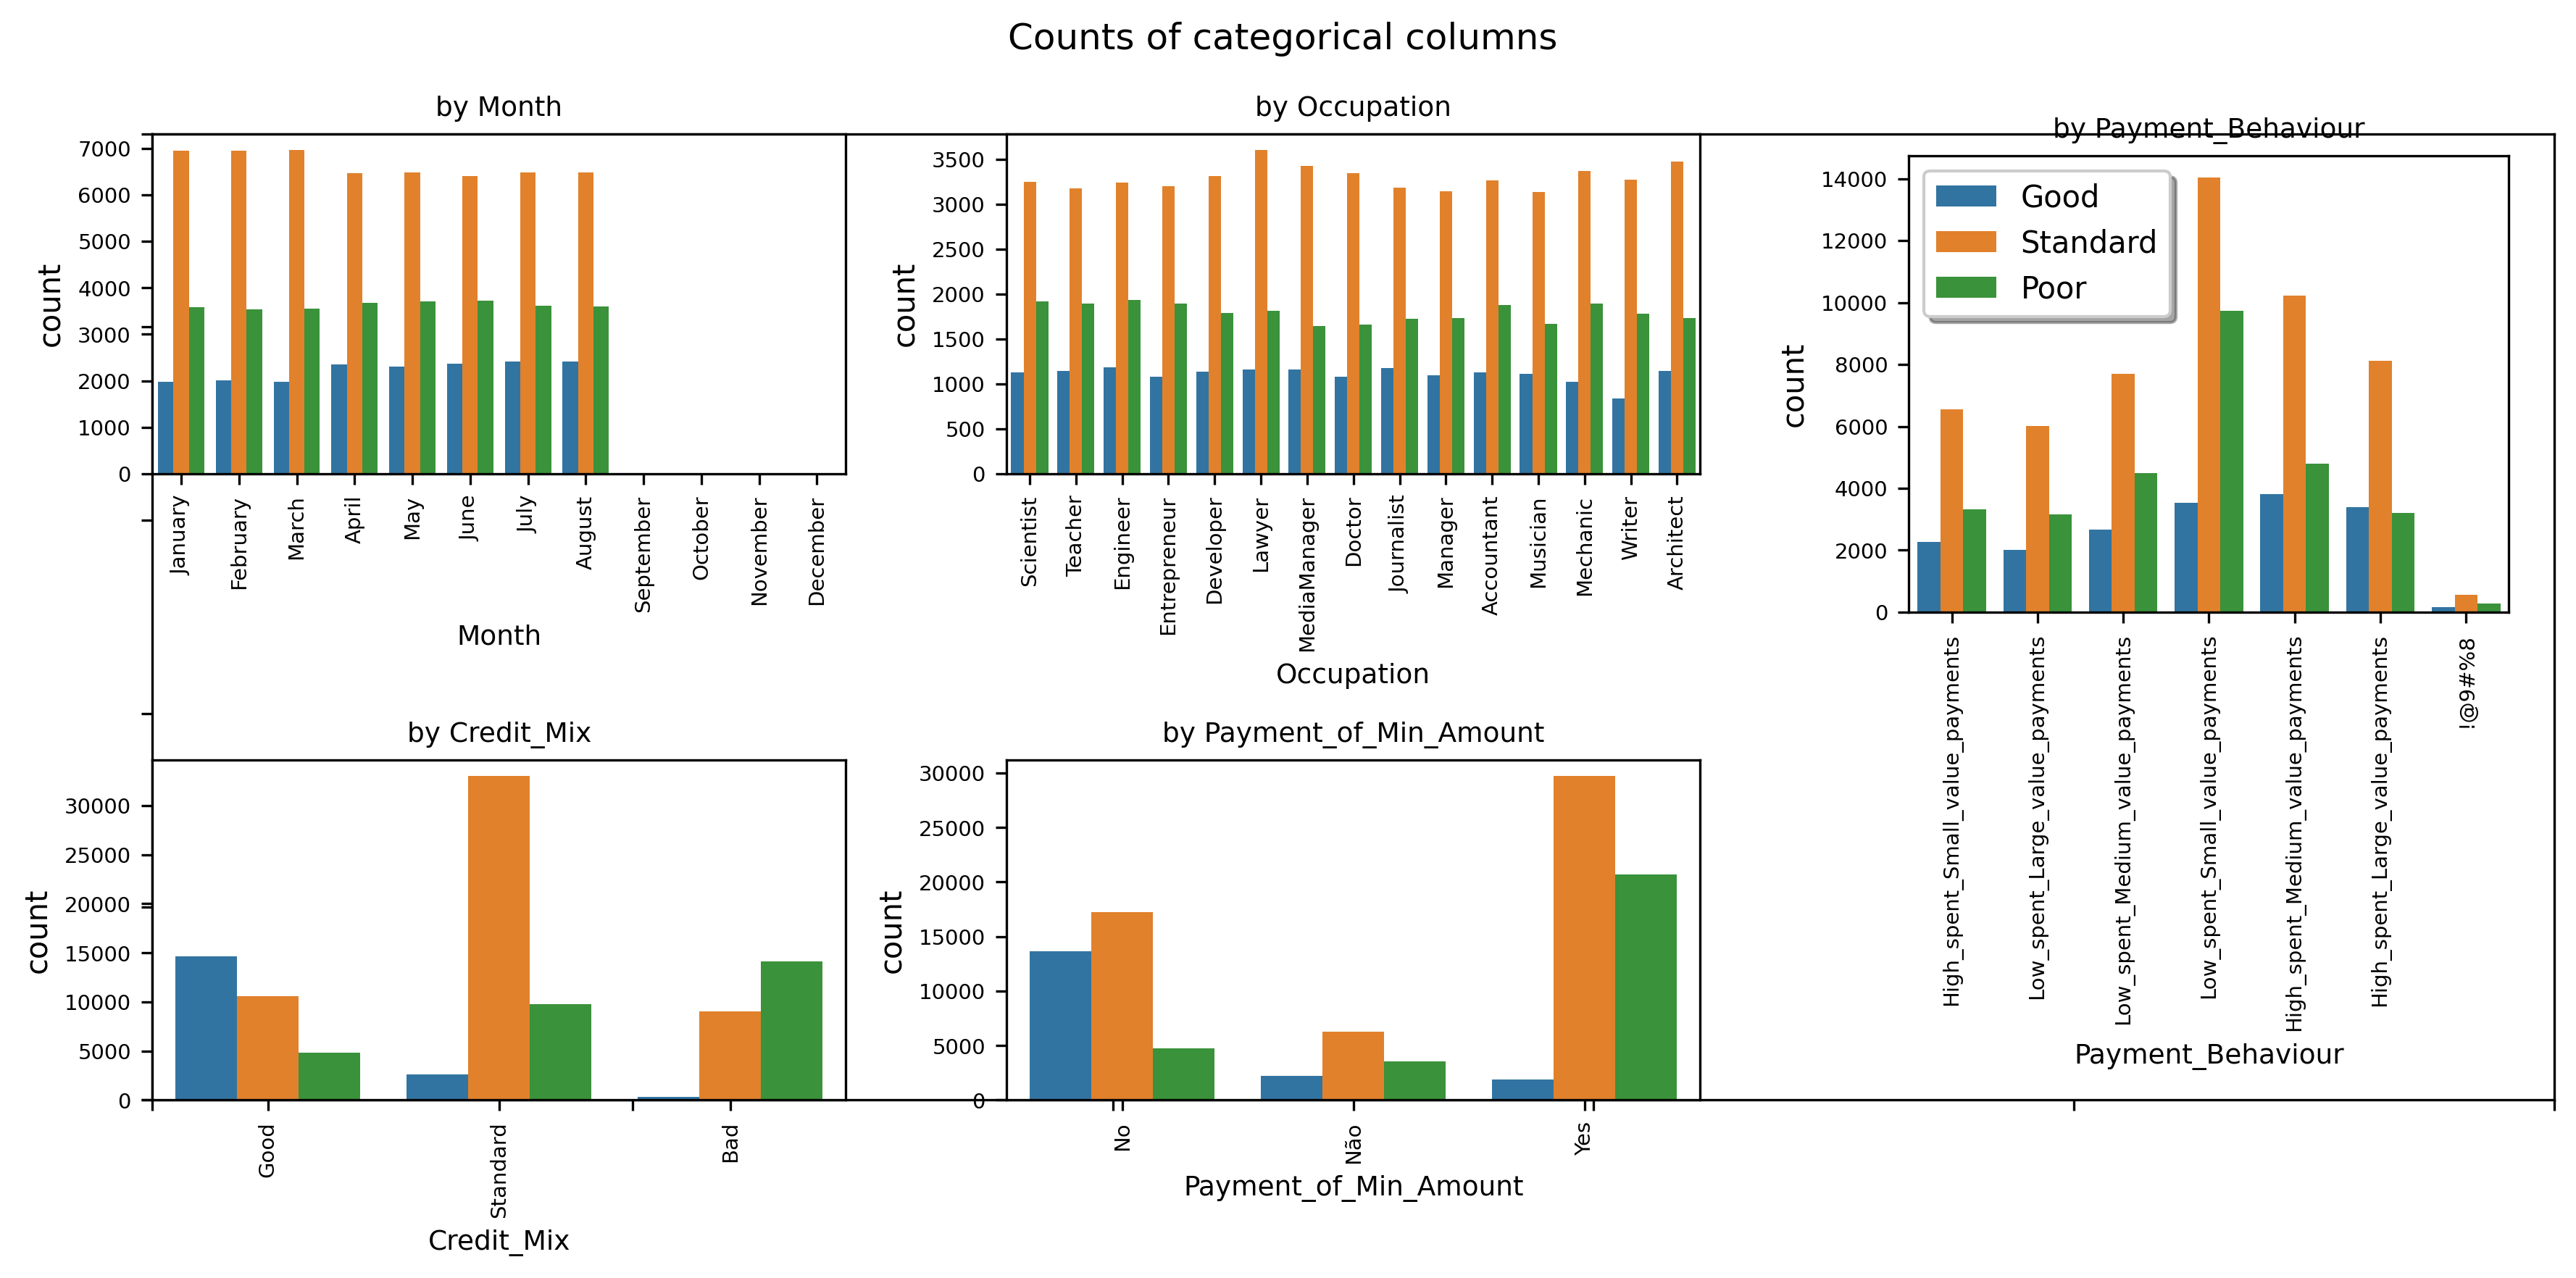

In [16]:
make_countplot(df)

## Heatmap e *correlações*

O código Python fornecido calcula e visualiza a matriz de correlação entre as variáveis numéricas do conjunto de dados, excluindo a coluna "treino". Aqui está a explicação detalhada:

1. **Matriz de Correlação**
- Calcula uma matriz (`corr`) que quantifica as relações lineares entre pares de variáveis numéricas
- Cada célula contém um coeficiente de correlação que varia de:
  - **-1**: Correlação negativa perfeita
  - **0**: Nenhuma correlação  
  - **+1**: Correlação positiva perfeita <br><br>

2. **Ocultando o Triângulo Superior**
- Aplica uma máscara (`mask`) para esconder a parte triangular superior da matriz
- Isso evita redundância pois a matriz de correlação é simétrica <br><br>

3. **Visualização com Mapa de Calor**
- Utiliza `sns.heatmap` do Seaborn para criar a visualização
- Inclui anotações com os valores de correlação em porcentagem
- Permite identificar rapidamente:
  - Correlações fortes (positivas ou negativas)
  - Possível multicolinearidade entre variáveis <br><br>

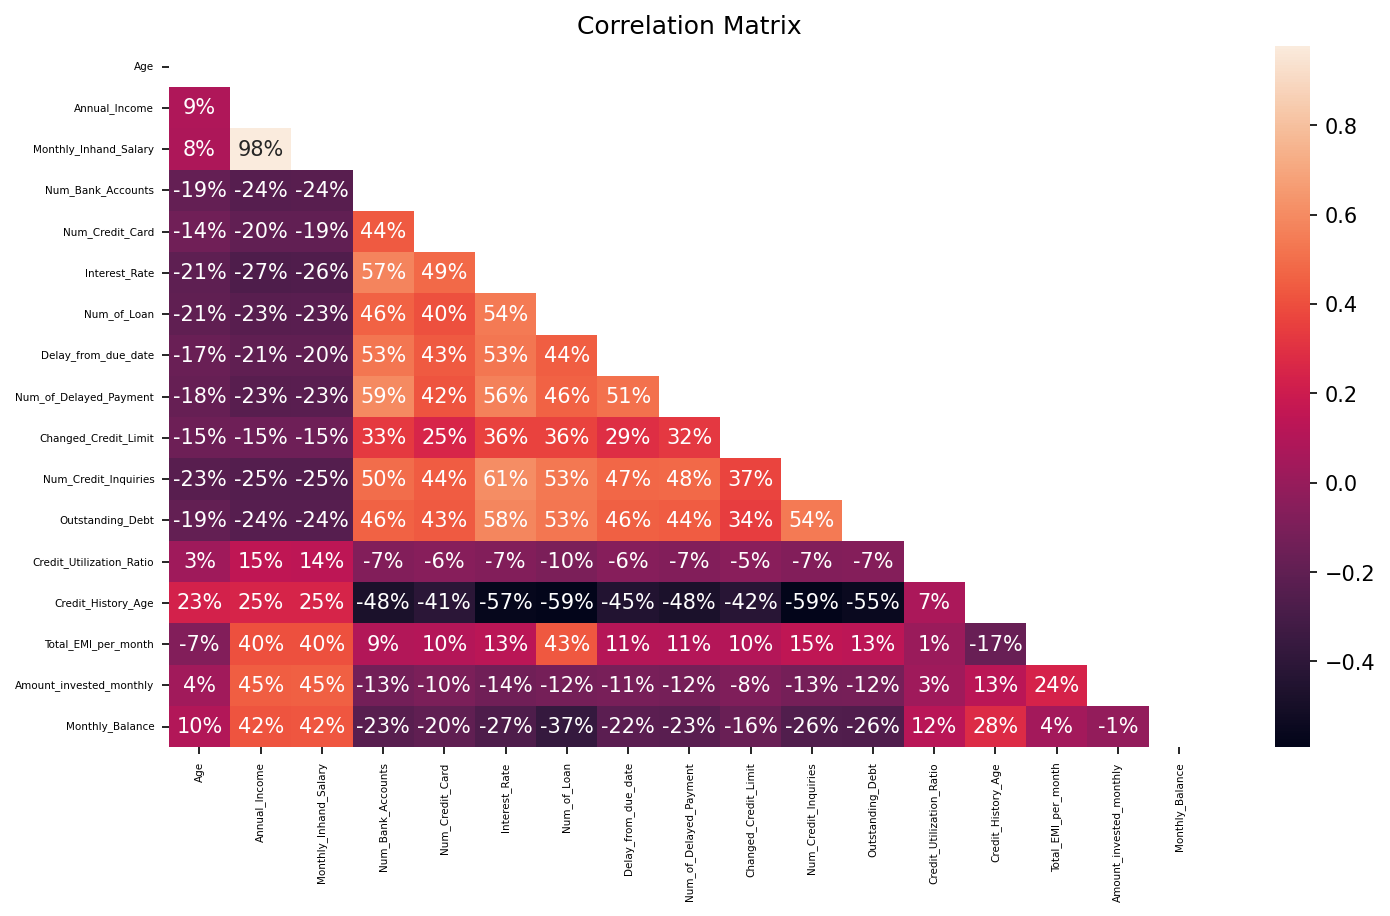

In [17]:
corr = data.drop(["treino"], axis=1).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 6), dpi=150)

sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
plt.grid(False)
plt.tick_params(axis="both", labelsize=5)
plt.tight_layout()
plt.title("Correlation Matrix")
plt.show()

## Testes de Hipóteses com Chi-Quadrado e Testes F

Este código Python define uma função `chi_2_test` que realiza testes de hipóteses para avaliar a relação entre colunas categóricas/numéricas e a variável alvo `'Credit_Score'`.

* **Funcionamento da Função `chi_2_test`** <br><br>
1. **Preparação dos Dados**:
   - Cria uma cópia do DataFrame contendo apenas dados de treino
   - Seleciona colunas categóricas e numéricas de interesse <br><br>

2. **Armazenamento de Resultados**:
   - Inicializa um array NumPy vazio para guardar os resultados dos testes <br><br> 

3. **Execução dos Testes**:
   - **Teste Chi-Quadrado**: Para colunas categóricas (avalia independência em relação a 'Credit_Score')
   - **Teste F (ANOVA)**: Para colunas numéricas (avalia variância explicada em 'Credit_Score') <br><br>


### Função

In [18]:
def chi_2_test(df:pd.DataFrame):
    df_copy = df.loc[df["treino"]].copy()
    cat_cols = df_copy.select_dtypes(exclude="number").columns.drop(["Customer_ID", "Month", "treino", "Credit_Score"])
    numb_columns = df_copy.select_dtypes(include="number").columns

    summary = np.empty((len(cat_cols)+len(numb_columns), 3), dtype="object")
    y, *_ = df_copy["Credit_Score"].factorize(sort=False)

    def perform_test(*args, test):

        if test == "chi2":
            for i, col in enumerate(args[0]):
                cross = pd.crosstab(index=df[col], columns=[df["Credit_Score"]])
                t_stat, pvalue, *_ = chi2_contingency(cross)
                summary[i, :] = [col, t_stat, pvalue]

        elif test=="f_classif":
            for i, col in enumerate(args[0], start=len(summary)-len(args[0])):
                t_stat, pvalue = f_classif(df_copy[[col]], y.reshape(-1, 1))
                summary[i, :] = [col, t_stat[0], pvalue[0]]

    perform_test(cat_cols, test="chi2")
    perform_test(numb_columns, test="f_classif")

    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )

In [19]:
chi2_summary = chi_2_test(data).sort_values(by="t-statistic", ascending=False)

### Gráfico e tabelas

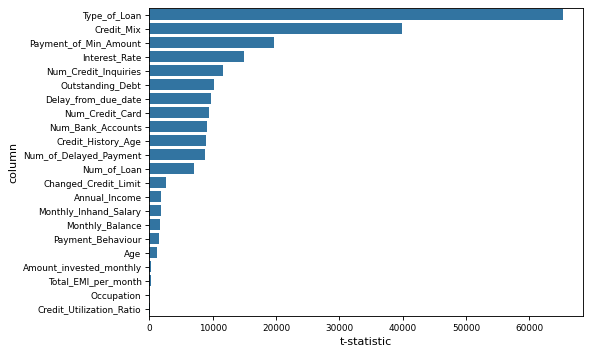

In [20]:
chi2_summary.style.bar("t-statistic").background_gradient(
    "Blues", subset="t-statistic")

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=chi2_summary, y="column", x="t-statistic", ax=ax)
plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], size=8)
fig.show()

##  Função `transform_columns()`

## **Objetivo Principal**
Cria um pré-processador completo para DataFrames que:
1. **Trata colunas numéricas e categóricas separadamente**
2. **Aplica transformações específicas para cada tipo de dado**
3. **Retorna um ColumnTransformer pronto para uso**

In [21]:
def transform_columns(data_frame: pd.DataFrame):
    category = data_frame.select_dtypes(exclude="number").columns.tolist()
    number =data_frame.select_dtypes(include="number").columns.tolist()


    def build_pipeline_numb(strategy="median"):
        pipe1 = Pipeline(steps=[
            ("imputer", IterativeImputer(initial_strategy=strategy, random_state=42)),
            ("scaling", MinMaxScaler()),
            # ("pca", PCA(0.98))
            # ("scaling", PowerTransformer())

        ])
        return pipe1

    def build_pipeline_cat(strategy="most_frequent"):
        pipe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=strategy))
])
        return pipe2

    transformer = ColumnTransformer(
        [
            ("cat_transformer", build_pipeline_cat(), category),
            ("numb_transformer", build_pipeline_numb(), number)
        ],
        remainder="drop"
    )
    transformer.fit(data_frame)
    return transformer

## Transformação de Dados com Pipelines Customizados

Este código Python define uma função de transformação de dados (`transform_columns`) que utiliza pipelines customizados para pré-processamento de colunas categóricas e numéricas em um DataFrame.

### **Funcionamento da Função `transform_columns`**

1. **Seleção de Colunas**:
   - Identifica automaticamente colunas categóricas e numéricas
   - Cria listas separadas para cada tipo de dado <br><br>


In [22]:
def split_data(data: pd.DataFrame, test_size=0.2) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    df_copy = data.copy()
    df_copy.drop(columns = ["Month", "Customer_ID"], inplace=True)
    df_copy["Delay_from_due_date"] = df_copy["Delay_from_due_date"].abs()

    train_set = df_copy[df_copy["treino"]].drop(["treino"], axis=1)
    test_set = df_copy[df_copy["treino"] == False].drop(
        ["treino", "Credit_Score"], axis=1).reset_index(drop=True)

    X = train_set.drop("Credit_Score", axis=1)
    y = train_set.pop("Credit_Score")

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, stratify=y, random_state=2, shuffle=True)
    return ((Xtrain, Xtest, ytrain, ytest), test_set)


def combined_transformers(data, save_to_pickle=False):
    outlier_remover = ClipOutliersTransformer(0.25, 0.75, multiply_by=1.5, replace_with_median=False)
    outlier_remover.fit(data.select_dtypes("number"))
    transformer = transform_columns(data)
    if save_to_pickle:
        file1 = open("OutlierRemover.pkl", "wb")
        file2 = open("ColumnsTransformers.pkl", "wb")
        pickle.dump(outlier_remover, file1)
        pickle.dump(transformer, file2)
    return (outlier_remover, transformer)


def get_transformed_data(data, transformers_to_pkl=False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_set, test_set = split_data(data)
    Xtrain, Xtest, ytrain, ytest = train_set
    _, transformer = combined_transformers(Xtrain, save_to_pickle=transformers_to_pkl)

    columns = list(itertools.chain.from_iterable([transformer[-1] for transformer in transformer.__dict__.get("transformers")]))
    Xtrain = pd.DataFrame(transformer.transform(Xtrain), columns=columns).apply(pd.to_numeric, errors="ignore")
    Xtest = pd.DataFrame(transformer.transform(Xtest), columns=columns).apply(pd.to_numeric, errors="ignore")
    test_set = pd.DataFrame(transformer.transform(test_set), columns=columns).apply(pd.to_numeric, errors="ignore")
    return ((Xtrain, Xtest), (ytrain, ytest), test_set)


((Xtrain, Xtest), (ytrain, ytest), test_set) = get_transformed_data(data, transformers_to_pkl=True)

cat_columns = Xtrain.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]


## Funções de Treinamento do Modelo CatBoost

Estas funções Python são projetadas para treinar modelos CatBoost de forma eficiente em tarefas de aprendizado de máquina:

- **Função `create_pool`**: Prepara os dados de treino e teste criando CatBoost Pools, que são estruturas de dados otimizadas para modelos CatBoost. Recebe como argumentos as features de entrada (`xtrain`, `ytrain`, `xtest`, `ytest`), features categóricas (`cat_features`) e features de texto (`text_features`), retornando os CatBoost Pools correspondentes para os dados de treino e teste.

- **Função `catboost_model`**: Configura um CatBoostClassifier com parâmetros padrão e personalizados, como número de iterações, métricas de avaliação customizadas e configurações de multi-threading. Os usuários podem fornecer parâmetros adicionais para personalizar ainda mais o modelo.

- **Função `fit_model`**: A função principal de treinamento que combina as duas funções anteriores. Cria os data pools, configura o modelo CatBoost, ajusta o modelo aos dados de treino enquanto avalia nos dados de teste, e permite early stopping e argumentos adicionais (keyword arguments).

Estas funções simplificam o processo de treinamento de modelos CatBoost, facilitando o preparo dos dados, a configuração do modelo e o treinamento com opções personalizáveis.

## Função

In [23]:
def create_pool(xtrain, ytrain, xtest, ytest, cat_features, text_features):
    Xtrain_pool = Pool(data=xtrain, label=ytrain, cat_features=cat_features, text_features=text_features)
    Xtest_pool = Pool(data=xtest, label=ytest, cat_features=cat_features, text_features=text_features)
    return (Xtrain_pool, Xtest_pool)


def catboost_model(params = {}):
    cb_params = {
        "iterations": 7500,
        "custom_metric": ["F1", "AUC", "Accuracy"],
        "thread_count":-1,
        "random_state": 42,
        "train_dir": "/catboost"
        
    }
    cb_params.update(params)

    model = CatBoostClassifier(**cb_params)
    return model


def fit_model(xtrain, ytrain, xtest, ytest, cat_features, text_features, params = {}, **kwargs):
    Xtrain_pool, Xtest_pool = create_pool(xtrain, ytrain, xtest, ytest, cat_features, text_features)
    model = catboost_model(params = params)
    model.fit(Xtrain_pool, eval_set=Xtest_pool, early_stopping_rounds=500, **kwargs)
    return model

## Treinamento do Classificador CatBoost

O código Python fornecido define uma função, `fit_model`, para treinar um classificador CatBoost em dados rotulados. Esta função recebe dados de treino e teste juntamente com vários parâmetros como features categóricas e de texto, além de parâmetros opcionais personalizados para o modelo CatBoost.

- **Preparação dos Dados**: A função primeiro cria CatBoost Pools para os dados de treino e teste, considerando features categóricas e de texto. Esses pools são estruturas de dados otimizadas que o CatBoost utiliza para treinamento eficiente.

- **Configuração e Treinamento do Modelo**: Configura o CatBoostClassifier, incluindo número de iterações, métricas personalizadas e configurações de multithreading, e então ajusta o modelo aos dados de treino enquanto avalia nos dados de teste. O parâmetro "early_stopping_rounds" permite early stopping para prevenir overfitting.
     
- **Personalização**: A função permite que usuários especifiquem parâmetros adicionais do CatBoost através do argumento "params" e controlem a verbosidade do treinamento com o argumento "verbose". Também fornece a opção de visualizar o progresso do treinamento com o parâmetro "plot".

In [24]:
model = fit_model(
    Xtrain, ytrain,
    Xtest, ytest,
    cat_columns, text_column,
    plot=False,
    verbose=500,
    params = {
        "iterations": 7500,
        "learning_rate": 0+
        .05,
        "depth": 7,
        "l2_leaf_reg": 5,
        "loss_function": "MultiClass",      #
        "eval_metric": "MultiClass",      
        "auto_class_weights": "Balanced",
        "random_strength": 1.0,
        "bagging_temperature": 0.7,
        "border_count": 128,
        "one_hot_max_size": 10,
        "text_processing": ["BM25+Word|BoW+Word"],
        "early_stopping_rounds": 50
    }
)

0:	learn: 1.0654649	test: 1.0659458	best: 1.0659458 (0)	total: 299ms	remaining: 37m 21s
500:	learn: 0.5884752	test: 0.6302533	best: 0.6302533 (500)	total: 1m 4s	remaining: 15m 2s
1000:	learn: 0.5196176	test: 0.5877280	best: 0.5877280 (1000)	total: 2m 6s	remaining: 13m 42s
1500:	learn: 0.4701694	test: 0.5596955	best: 0.5596955 (1500)	total: 3m 16s	remaining: 13m 4s
2000:	learn: 0.4327825	test: 0.5407265	best: 0.5407265 (2000)	total: 4m 22s	remaining: 12m 2s
2500:	learn: 0.4025500	test: 0.5268879	best: 0.5268879 (2500)	total: 5m 25s	remaining: 10m 51s
3000:	learn: 0.3779379	test: 0.5162713	best: 0.5162713 (3000)	total: 6m 26s	remaining: 9m 39s
3500:	learn: 0.3563503	test: 0.5086417	best: 0.5086417 (3500)	total: 7m 22s	remaining: 8m 25s
4000:	learn: 0.3374124	test: 0.5021586	best: 0.5021498 (3995)	total: 8m 20s	remaining: 7m 17s
4500:	learn: 0.3203494	test: 0.4974347	best: 0.4974347 (4500)	total: 9m 31s	remaining: 6m 20s
5000:	learn: 0.3046671	test: 0.4936445	best: 0.4936445 (5000)	total:

In [25]:
w = catboost.MetricVisualizer('/catboost/')
w.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [26]:
Xtrain_pool, Xtest_pool = create_pool(Xtrain, ytrain, Xtest, ytest, cat_columns, text_column)

In [27]:
importance = model.get_feature_importance(Xtest_pool, type="LossFunctionChange", prettified=True)

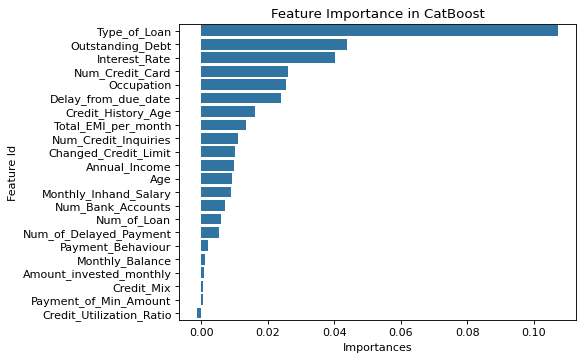

In [28]:
sns.barplot(data=importance, y="Feature Id", x = "Importances")
plt.title("Feature Importance in CatBoost")
plt.show()

## Refinamento do Modelo com Seleção de Features

Neste pipeline de machine learning, implementamos um processo completo de refinamento do modelo com seleção estratégica de features, utilizando o CatBoost como algoritmo principal:

### **Seleção e Pré-processamento de Features**
- O dataset pré-processado (`Xtrain1`, `Xtest1`) contém apenas as features mais relevantes após análise de importância
- Features categóricas são tratadas automaticamente via parâmetro `cat_columns`
- Textos são processados com técnicas avançadas especificadas em `text_processing`

### **Otimização dos parametros no Modelo CatBoost**

* `"iterations": 7500` - Define o número máximo de árvores de decisão que serão construídas durante o treinamento
* `"learning_rate": 0.05` - Controla o tamanho do passo em cada atualização dos pesos do modelo (eta)
* `"depth": 7` - Especifica a profundidade máxima de cada árvore no ensemble
* `"l2_leaf_reg": 5` - Parâmetro de regularização L2 para prevenir overfitting
* `"loss_function": "MultiClass"` - Função de perda otimizada para problemas de classificação multiclasse
* `"eval_metric": "MultiClass"` - Métrica de avaliação usada para monitorar o desempenho
* `"auto_class_weights": "Balanced"` - Ajusta automaticamente os pesos das classes para datasets desbalanceados
* `"random_strength": 1.0` - Intensidade da aleatorização nos splits das árvores
* `"bagging_temperature": 0.7` - Controla a intensidade do bayesian bagging
* `"border_count": 128` - Número de divisões para variáveis numéricas
* `"one_hot_max_size": 10` - Tamanho máximo para aplicar one-hot encoding em categorias
* `"text_processing": ["BM25+Word|BoW+Word"]` - Configurações avançadas para processamento de texto:
   1. BM25: Modelo de ranking para relevância de termos
   2. BoW: Bag-of-Words tradicional
   3. Combinação híbrida com tokenização por palavras <br><br>

* `"early_stopping_rounds": 50` - Critério de parada antecipada se não houver melhorave tasks.


In [29]:
df_copy = data.copy().drop(importance.query("Importances < 0.000")["Feature Id"], axis=1)
((Xtrain1, Xtest1), (ytrain1, ytest1), test_set) = get_transformed_data(df_copy, transformers_to_pkl=True)

cat_columns = Xtrain1.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]

In [30]:
model_refined = fit_model(
    Xtrain1, ytrain1,
    Xtest1, ytest1,
    cat_columns, text_column,
    plot=False,
    verbose=500,
     params = {
        "iterations": 7500,
        "learning_rate": 0.05,
        "depth": 7,
        "l2_leaf_reg": 5,
        "loss_function": "MultiClass",     
        "eval_metric": "MultiClass",       
        "auto_class_weights": "Balanced",
        "random_strength": 1.0,
        "bagging_temperature": 0.7,
        "border_count": 128,
        "one_hot_max_size": 10,
        "text_processing": ["BM25+Word|BoW+Word"],
        "early_stopping_rounds": 50
    }
)

0:	learn: 1.0637843	test: 1.0642734	best: 1.0642734 (0)	total: 136ms	remaining: 16m 57s
500:	learn: 0.5883947	test: 0.6297628	best: 0.6297628 (500)	total: 1m 6s	remaining: 15m 30s
1000:	learn: 0.5194415	test: 0.5862381	best: 0.5862381 (1000)	total: 2m 20s	remaining: 15m 15s
1500:	learn: 0.4716764	test: 0.5578017	best: 0.5578017 (1500)	total: 3m 32s	remaining: 14m 8s
2000:	learn: 0.4337888	test: 0.5368992	best: 0.5368992 (2000)	total: 4m 43s	remaining: 12m 58s
2500:	learn: 0.4032982	test: 0.5217417	best: 0.5217417 (2500)	total: 5m 53s	remaining: 11m 46s
3000:	learn: 0.3783968	test: 0.5110689	best: 0.5110650 (2998)	total: 7m 3s	remaining: 10m 35s
3500:	learn: 0.3571159	test: 0.5022772	best: 0.5022772 (3500)	total: 8m 15s	remaining: 9m 26s
4000:	learn: 0.3381980	test: 0.4958177	best: 0.4958104 (3999)	total: 9m 27s	remaining: 8m 15s
4500:	learn: 0.3218763	test: 0.4910109	best: 0.4910109 (4500)	total: 10m 37s	remaining: 7m 4s
5000:	learn: 0.3067618	test: 0.4871158	best: 0.4871158 (5000)	tot

In [31]:
model_refined.save_model("credit_score_prediction_model-cb-v1")

# Model Evaluation

In [32]:
loaded_model = CatBoostClassifier()
loaded_model.load_model(r"credit_score_prediction_model-cb-v1")

Accuracy: 79.86%
F1 Score: {'Good': '75.87%', 'Poor': '81.64%', 'Standard': '80.38%'}
Precision Score: {'Good': '68.15%', 'Poor': '77.64%', 'Standard': '87.20%'}
Recall Score: {'Good': '85.56%', 'Poor': '86.08%', 'Standard': '74.56%'}



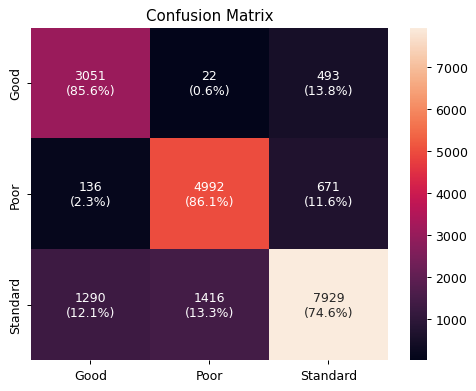

In [33]:
y_hat = loaded_model.predict(Xtest[loaded_model.feature_names_])
acc_score = accuracy_score(ytest, y_hat)
f1 = f1_score(ytest, y_hat, average=None)
precision = precision_score(ytest, y_hat, average=None)
recall = recall_score(ytest, y_hat, average=None)

print(f"Accuracy: {acc_score:.2%}\n\
F1 Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', f1)))}\n\
Precision Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', precision)))}\n\
Recall Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', recall)))}\n\
")


cm = confusion_matrix(ytest, y_hat)
cm_norm = confusion_matrix(ytest, y_hat, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)

fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=loaded_model.classes_, yticklabels=loaded_model.classes_)
plt.title("Confusion Matrix")
plt.show()

## Métricas de Avaliação do Modelo

Estas métricas de avaliação fornecem insights sobre o desempenho de um modelo de classificação:

- **Acurácia**: A pontuação de acurácia é `79.27%`, indicando a proporção de previsões corretas em relação ao total de previsões feitas pelo modelo. Essa métrica mede a correção geral da classificação. <br><br>

- **F1 Score**: O F1 score é uma métrica composta que equilibra precisão e recall. Os valores reportados para as três classes são:
  - 'Good': `75.87%`
  - 'Poor': `81.64%`
  - 'Standard': `80.38%`
  Valores mais altos de F1 indicam um melhor equilíbrio entre precisão e recall para cada classe. <br><br>

- **Precisão**: A precisão mede a acurácia das previsões positivas. Os valores por classe são:
  - 'Good': `68.15%`
  - 'Poor': `77.64%`
  - 'Standard': `87.20%`
  Estes valores representam a proporção de verdadeiros positivos em relação a todas as previsões positivas feitas pelo modelo. <br><br>

- **Recall (Sensibilidade)**: O recall, também conhecido como sensibilidade ou taxa de verdadeiros positivos, mede a capacidade do modelo de identificar corretamente instâncias positivas. Os valores por classe são:
  - 'Good': `85.56%`
  - 'Poor': `86.08%`
  - 'Standard': `74.56%`
  Estes valores representam a proporção de verdadeiros positivos em relação a todas as instâncias positivas reais.

Estas métricas fornecem coletivamente uma avaliação abrangente do desempenho do modelo em diferentes aspectos da acurácia de classificação e sua capacidade de distinguir entre as classes alvo.